In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 150
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 5000 

In [11]:
def initialization(weights_root=None): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())

    if weights_root is not None:     
        print("model is loaded on {}".format(weights_root))
        actor_model.load_weights("./{}/actor_model.h5".format(weights_root))
        critic_model.load_weights("./{}/critic_model.h5".format(weights_root))
        target_actor.load_weights("./{}/target_actor.h5".format(weights_root))
        target_critic.load_weights("./{}/target_critic.h5".format(weights_root))
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor, consider_degradation):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor, consider_degradation)
    return env 

In [14]:
def test_agent(actor_model, reward_factor, consider_degradation):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor, consider_degradation)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    degradation_total = np.sum(np.array(env.history["degradation"])) 
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
        "SOC: {:.4f}".format(env.SOC), 
        "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
        "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        "Degradation total: {:.4f}".format(degradation_total))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    

In [15]:
def update_reward_factor(reward_factor_temp, result_dict, thresh): 
    histories = result_dict["train_history"]
    SOCs = [env_history["SOC"][-1] for env_history in histories] 
#     SOCs = result_dict["SOCs"]
    SOC_at_equilibrium = np.mean(SOCs[-10:])
    if abs(SOC_at_equilibrium - 0.6) < thresh: 
        terminal = True 
        reward_factor = reward_factor_temp 
    else: 
        terminal = False 
        reward_factor = reward_factor_temp + 5 * (0.6 - SOC_at_equilibrium)
    return reward_factor, terminal 

In [16]:
results_dict = {} 
reward_factor_temp = 2 
consider_degradation = False 

driving_cycle_path = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
driving_cycle = sio.loadmat(driving_cycle_path)
driving_cycle = driving_cycle["sch_cycle"][:, 1]
while True: 
    print("")
    print("reward factor = {}".format(reward_factor_temp))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_train_history = []
    for ep in range(total_episodes): 
        env = initialization_env(driving_cycle, reward_factor_temp, consider_degradation)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 
        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_train_history.append(env.history)
        
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        degradation_total = np.sum(np.array(env.history["degradation"]))
        print(
            'Episode: {}'.format(ep + 1),
            "Exploration P: {:.4f}".format(eps),
            'Total reward: {}'.format(episodic_reward), 
            "SOC: {:.4f}".format(env.SOC), 
            "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
            "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
            "Total Degradation: {:.4f}".format(degradation_total)
        )
        print("")
        
            
    root = "./noDegradation/reward_factor{}".format(reward_factor_temp)
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[reward_factor_temp] = {
        "rewards": episode_rewards, 
        "train_history": episode_train_history 
    }
    
    reward_factor_temp, terminal = update_reward_factor(reward_factor_temp, 
                                                        results_dict[reward_factor_temp], 
                                                        0.015) 
    if terminal: 
        break 
    
    


reward factor = 2

maximum steps, simulation is done ... 
elapsed_time: 10.998
Episode: 1 Exploration P: 1.0000 Total reward: -1157.600774043968 SOC: 0.9993 Cumulative_SOC_deviation: 483.5535 Fuel Consumption: 190.4938 Total Degradation: 524.7037

maximum steps, simulation is done ... 
elapsed_time: 10.533
Episode: 2 Exploration P: 1.0000 Total reward: -1156.2974056565624 SOC: 1.0000 Cumulative_SOC_deviation: 482.8142 Fuel Consumption: 190.6690 Total Degradation: 525.1414

maximum steps, simulation is done ... 
elapsed_time: 10.115
Episode: 3 Exploration P: 1.0000 Total reward: -1158.1458442705218 SOC: 0.9999 Cumulative_SOC_deviation: 482.4912 Fuel Consumption: 193.1635 Total Degradation: 523.8406


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64'

maximum steps, simulation is done ... 
elapsed_time: 76.123
Episode: 24 Exploration P: 0.5761 Total reward: -528.2552574002185 SOC: 0.9305 Cumulative_SOC_deviation: 188.9606 Fuel Consumption: 150.3341 Total Degradation: 431.4440

maximum steps, simulation is done ... 
elapsed_time: 83.889
Episode: 25 Exploration P: 0.5607 Total reward: -680.6036671204171 SOC: 0.9583 Cumulative_SOC_deviation: 264.2689 Fuel Consumption: 152.0658 Total Degradation: 430.9642

maximum steps, simulation is done ... 
elapsed_time: 76.973
Episode: 26 Exploration P: 0.5458 Total reward: -468.91937374399345 SOC: 0.8779 Cumulative_SOC_deviation: 161.3285 Fuel Consumption: 146.2625 Total Degradation: 419.2967

maximum steps, simulation is done ... 
elapsed_time: 93.982
Episode: 27 Exploration P: 0.5313 Total reward: -474.4737742615233 SOC: 0.9175 Cumulative_SOC_deviation: 162.4048 Fuel Consumption: 149.6641 Total Degradation: 408.4859

maximum steps, simulation is done ... 
elapsed_time: 94.299
Episode: 28 Explora

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:270: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


maximum steps, simulation is done ... 
elapsed_time: 80.703
Episode: 42 Exploration P: 0.3553 Total reward: -962.0182043415175 SOC: 0.0561 Cumulative_SOC_deviation: 437.0029 Fuel Consumption: 88.0124 Total Degradation: 311.4972

maximum steps, simulation is done ... 
elapsed_time: 72.585
Episode: 43 Exploration P: 0.3459 Total reward: -837.7240279507813 SOC: 0.1551 Cumulative_SOC_deviation: 371.3820 Fuel Consumption: 94.9599 Total Degradation: 308.1443

maximum steps, simulation is done ... 
elapsed_time: 73.199
Episode: 44 Exploration P: 0.3368 Total reward: -954.7731203787026 SOC: 0.0820 Cumulative_SOC_deviation: 432.0197 Fuel Consumption: 90.7337 Total Degradation: 291.4597

maximum steps, simulation is done ... 
elapsed_time: 71.151
Episode: 45 Exploration P: 0.3280 Total reward: -950.0602825102762 SOC: 0.0477 Cumulative_SOC_deviation: 431.1734 Fuel Consumption: 87.7135 Total Degradation: 283.9728

maximum steps, simulation is done ... 
elapsed_time: 71.201
Episode: 46 Exploration 

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:271: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


battery power is 6289.483109771652(+) but condition is not avail
elapsed_time: 49.053
Episode: 54 Exploration P: 0.2670 Total reward: [-1680.55414952] SOC: -0.0001 Cumulative_SOC_deviation: 315.5427 Fuel Consumption: 50.6699 Total Degradation: 172.3316

battery power is 9421.963790156098(+) but condition is not avail
elapsed_time: 53.002
Episode: 55 Exploration P: 0.2619 Total reward: [-1744.60165881] SOC: -0.0005 Cumulative_SOC_deviation: 344.4309 Fuel Consumption: 56.9418 Total Degradation: 180.4563

battery power is 8687.290173603826(+) but condition is not avail
elapsed_time: 49.334
Episode: 56 Exploration P: 0.2574 Total reward: [-1614.6826966] SOC: -0.0008 Cumulative_SOC_deviation: 283.8857 Fuel Consumption: 48.1138 Total Degradation: 162.2872

battery power is 2701.524265944465(+) but condition is not avail
elapsed_time: 47.197
Episode: 57 Exploration P: 0.2531 Total reward: [-1610.13412834] SOC: -0.0004 Cumulative_SOC_deviation: 282.5737 Fuel Consumption: 46.2812 Total Degradat

battery power is 12112.741162676295(+) but condition is not avail
elapsed_time: 33.982
Episode: 90 Exploration P: 0.1140 Total reward: [-1350.34450923] SOC: -0.0004 Cumulative_SOC_deviation: 167.6712 Fuel Consumption: 16.2036 Total Degradation: 50.0015

battery power is 1734.955034069886(+) but condition is not avail
elapsed_time: 35.055
Episode: 91 Exploration P: 0.1128 Total reward: [-1377.37456745] SOC: -0.0005 Cumulative_SOC_deviation: 180.2162 Fuel Consumption: 18.1439 Total Degradation: 56.3055

battery power is 11066.014603911986(+) but condition is not avail
elapsed_time: 36.819
Episode: 92 Exploration P: 0.1117 Total reward: [-1377.04939705] SOC: -0.0000 Cumulative_SOC_deviation: 179.2692 Fuel Consumption: 19.7118 Total Degradation: 66.3976

maximum steps, simulation is done ... 
elapsed_time: 88.820
Episode: 93 Exploration P: 0.1089 Total reward: -1164.5728638062892 SOC: 0.1471 Cumulative_SOC_deviation: 533.1656 Fuel Consumption: 98.2417 Total Degradation: 255.7632

battery p

battery power is 4855.669210900852(+) but condition is not avail
elapsed_time: 56.784
Episode: 124 Exploration P: 0.0647 Total reward: [-2021.34552331] SOC: -0.0005 Cumulative_SOC_deviation: 478.3386 Fuel Consumption: 65.9628 Total Degradation: 219.1068

battery power is 4771.432547073186(+) but condition is not avail
elapsed_time: 42.280
Episode: 125 Exploration P: 0.0639 Total reward: [-1930.7997392] SOC: -0.0007 Cumulative_SOC_deviation: 334.2135 Fuel Consumption: 263.5750 Total Degradation: 75.8468

maximum steps, simulation is done ... 
elapsed_time: 73.363
Episode: 126 Exploration P: 0.0624 Total reward: -1376.2760415860728 SOC: -0.0006 Cumulative_SOC_deviation: 615.5669 Fuel Consumption: 145.1422 Total Degradation: 172.9086

battery power is 8348.344284713574(+) but condition is not avail
elapsed_time: 68.567
Episode: 127 Exploration P: 0.0611 Total reward: [-2284.89947942] SOC: -0.0003 Cumulative_SOC_deviation: 595.1420 Fuel Consumption: 95.8169 Total Degradation: 152.5816

bat


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

maximum steps, simulation is done ... 
elapsed_time: 75.189
Episode: 31 Exploration P: 0.4771 Total reward: -472.68620295415724 SOC: 0.6830 Cumulative_SOC_deviation: 68.4823 Fuel Consumption: 132.2643 Total Degradation: 386.4566

maximum steps, simulation is done ... 
elapsed_time: 74.543
Episode: 32 Exploration P: 0.4644 Total reward: -336.2079285282539 SOC: 0.7073 Cumulative_SOC_deviation: 40.6186 Fuel Consumption: 134.2950 Total Degradation: 386.4529

maximum steps, simulation is done ... 
elapsed_time: 75.212
Episode: 33 Exploration P: 0.4521 Total reward: -713.9817446492348 SOC: 0.5247 Cumulative_SOC_deviation: 119.4435 Fuel Consumption: 120.2350 Total Degradation: 361.8638

maximum steps, simulation is done ... 
elapsed_time: 79.356
Episode: 34 Exploration P: 0.4401 Total reward: -987.0750116129627 SOC: 0.4734 Cumulative_SOC_deviation: 175.1569 Fuel Consumption: 116.3798 Total Degradation: 348.1279

maximum steps, simulation is done ... 
elapsed_time: 79.031
Episode: 35 Explorati

maximum steps, simulation is done ... 
elapsed_time: 98.732
Episode: 67 Exploration P: 0.1838 Total reward: -245.0274892139463 SOC: 0.6038 Cumulative_SOC_deviation: 26.3699 Fuel Consumption: 113.9440 Total Degradation: 533.9632

maximum steps, simulation is done ... 
elapsed_time: 96.254
Episode: 68 Exploration P: 0.1791 Total reward: -241.53724717769975 SOC: 0.5759 Cumulative_SOC_deviation: 26.1586 Fuel Consumption: 111.5043 Total Degradation: 544.7524

maximum steps, simulation is done ... 
elapsed_time: 94.347
Episode: 69 Exploration P: 0.1745 Total reward: -256.05270052287165 SOC: 0.5750 Cumulative_SOC_deviation: 29.1767 Fuel Consumption: 111.0168 Total Degradation: 554.7339

maximum steps, simulation is done ... 
elapsed_time: 94.878
Episode: 70 Exploration P: 0.1701 Total reward: -260.8203827183022 SOC: 0.5782 Cumulative_SOC_deviation: 30.1782 Fuel Consumption: 110.8061 Total Degradation: 572.1424

maximum steps, simulation is done ... 
elapsed_time: 96.287
Episode: 71 Exploratio

maximum steps, simulation is done ... 
elapsed_time: 100.423
Episode: 103 Exploration P: 0.0747 Total reward: -327.1927997709479 SOC: 0.5737 Cumulative_SOC_deviation: 44.2485 Fuel Consumption: 107.2361 Total Degradation: 572.5633

maximum steps, simulation is done ... 
elapsed_time: 100.977
Episode: 104 Exploration P: 0.0729 Total reward: -376.34594562179996 SOC: 0.5777 Cumulative_SOC_deviation: 54.0718 Fuel Consumption: 107.5578 Total Degradation: 573.3979

maximum steps, simulation is done ... 
elapsed_time: 97.195
Episode: 105 Exploration P: 0.0712 Total reward: -284.3270828727841 SOC: 0.5801 Cumulative_SOC_deviation: 35.5781 Fuel Consumption: 107.4704 Total Degradation: 573.3715

maximum steps, simulation is done ... 
elapsed_time: 100.141
Episode: 106 Exploration P: 0.0696 Total reward: -398.2054766158912 SOC: 0.5746 Cumulative_SOC_deviation: 58.5540 Fuel Consumption: 107.1369 Total Degradation: 565.4970

maximum steps, simulation is done ... 
elapsed_time: 99.141
Episode: 107 Exp

maximum steps, simulation is done ... 
elapsed_time: 77.711
Episode: 139 Exploration P: 0.0341 Total reward: -324.14583694435424 SOC: 0.5687 Cumulative_SOC_deviation: 43.9822 Fuel Consumption: 105.5130 Total Degradation: 568.4024

maximum steps, simulation is done ... 
elapsed_time: 80.589
Episode: 140 Exploration P: 0.0334 Total reward: -334.1693031738457 SOC: 0.5674 Cumulative_SOC_deviation: 45.9619 Fuel Consumption: 105.6952 Total Degradation: 574.6077

maximum steps, simulation is done ... 
elapsed_time: 77.940
Episode: 141 Exploration P: 0.0328 Total reward: -311.7282899792954 SOC: 0.5666 Cumulative_SOC_deviation: 41.4295 Fuel Consumption: 105.7847 Total Degradation: 574.6149

maximum steps, simulation is done ... 
elapsed_time: 81.150
Episode: 142 Exploration P: 0.0322 Total reward: -343.27399225168426 SOC: 0.5572 Cumulative_SOC_deviation: 47.9713 Fuel Consumption: 104.8114 Total Degradation: 574.6149

maximum steps, simulation is done ... 
elapsed_time: 79.701
Episode: 143 Explo

maximum steps, simulation is done ... 
elapsed_time: 76.734
Episode: 12 Exploration P: 0.7970 Total reward: -2455.9178192654126 SOC: 1.0000 Cumulative_SOC_deviation: 441.3827 Fuel Consumption: 168.2802 Total Degradation: 507.6873

maximum steps, simulation is done ... 
elapsed_time: 77.277
Episode: 13 Exploration P: 0.7757 Total reward: -2325.9533390192864 SOC: 0.9996 Cumulative_SOC_deviation: 416.5556 Fuel Consumption: 166.9917 Total Degradation: 500.2826

maximum steps, simulation is done ... 
elapsed_time: 77.181
Episode: 14 Exploration P: 0.7549 Total reward: -2372.0486915133483 SOC: 0.9988 Cumulative_SOC_deviation: 425.9525 Fuel Consumption: 164.3838 Total Degradation: 495.7103

maximum steps, simulation is done ... 
elapsed_time: 77.207
Episode: 15 Exploration P: 0.7347 Total reward: -2378.1434974117988 SOC: 1.0000 Cumulative_SOC_deviation: 427.5044 Fuel Consumption: 162.4356 Total Degradation: 504.0387

maximum steps, simulation is done ... 
elapsed_time: 78.857
Episode: 16 Expl

maximum steps, simulation is done ... 
elapsed_time: 95.201
Episode: 48 Exploration P: 0.3028 Total reward: -2011.9608758323116 SOC: 0.1961 Cumulative_SOC_deviation: 370.1638 Fuel Consumption: 93.4429 Total Degradation: 564.3092

maximum steps, simulation is done ... 
elapsed_time: 77.710
Episode: 49 Exploration P: 0.2949 Total reward: -1316.5109033332642 SOC: 0.3344 Cumulative_SOC_deviation: 234.5232 Fuel Consumption: 101.0031 Total Degradation: 565.5234

maximum steps, simulation is done ... 
elapsed_time: 77.353
Episode: 50 Exploration P: 0.2872 Total reward: -1253.515179824024 SOC: 0.3274 Cumulative_SOC_deviation: 222.4689 Fuel Consumption: 100.4836 Total Degradation: 568.8474

maximum steps, simulation is done ... 
elapsed_time: 79.302
Episode: 51 Exploration P: 0.2797 Total reward: -1513.9790558164977 SOC: 0.2443 Cumulative_SOC_deviation: 273.7944 Fuel Consumption: 94.9331 Total Degradation: 564.7009

maximum steps, simulation is done ... 
elapsed_time: 78.634
Episode: 52 Explora

maximum steps, simulation is done ... 
elapsed_time: 93.014
Episode: 84 Exploration P: 0.1190 Total reward: -481.2869969545786 SOC: 0.5408 Cumulative_SOC_deviation: 72.2956 Fuel Consumption: 106.5870 Total Degradation: 574.6542

maximum steps, simulation is done ... 
elapsed_time: 92.893
Episode: 85 Exploration P: 0.1160 Total reward: -485.087114296387 SOC: 0.5398 Cumulative_SOC_deviation: 72.9220 Fuel Consumption: 107.1404 Total Degradation: 573.8212

maximum steps, simulation is done ... 
elapsed_time: 94.143
Episode: 86 Exploration P: 0.1131 Total reward: -477.53371567084116 SOC: 0.5537 Cumulative_SOC_deviation: 71.4281 Fuel Consumption: 107.3297 Total Degradation: 572.1256

maximum steps, simulation is done ... 
elapsed_time: 93.272
Episode: 87 Exploration P: 0.1104 Total reward: -343.447495108393 SOC: 0.5466 Cumulative_SOC_deviation: 45.6567 Fuel Consumption: 106.8137 Total Degradation: 571.7191

maximum steps, simulation is done ... 
elapsed_time: 94.377
Episode: 88 Exploration P

maximum steps, simulation is done ... 
elapsed_time: 75.060
Episode: 120 Exploration P: 0.0505 Total reward: -359.1107241373541 SOC: 0.5652 Cumulative_SOC_deviation: 48.6687 Fuel Consumption: 106.8663 Total Degradation: 569.2009

maximum steps, simulation is done ... 
elapsed_time: 75.431
Episode: 121 Exploration P: 0.0495 Total reward: -378.94158208728305 SOC: 0.5663 Cumulative_SOC_deviation: 52.4875 Fuel Consumption: 106.9048 Total Degradation: 568.3735

maximum steps, simulation is done ... 
elapsed_time: 74.916
Episode: 122 Exploration P: 0.0484 Total reward: -383.12925908988774 SOC: 0.5543 Cumulative_SOC_deviation: 53.4334 Fuel Consumption: 106.1900 Total Degradation: 569.2033

maximum steps, simulation is done ... 
elapsed_time: 83.180
Episode: 123 Exploration P: 0.0473 Total reward: -425.6225310834574 SOC: 0.5606 Cumulative_SOC_deviation: 61.5740 Fuel Consumption: 106.4911 Total Degradation: 570.4564

maximum steps, simulation is done ... 
elapsed_time: 88.066
Episode: 124 Explo


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

maximum steps, simulation is done ... 
elapsed_time: 73.324
Episode: 31 Exploration P: 0.4771 Total reward: -393.66350913755633 SOC: 0.6642 Cumulative_SOC_deviation: 48.0321 Fuel Consumption: 130.6666 Total Degradation: 383.1138

maximum steps, simulation is done ... 
elapsed_time: 72.980
Episode: 32 Exploration P: 0.4644 Total reward: -611.7898812204553 SOC: 0.6269 Cumulative_SOC_deviation: 88.2458 Fuel Consumption: 128.6050 Total Degradation: 368.5309

maximum steps, simulation is done ... 
elapsed_time: 72.248
Episode: 33 Exploration P: 0.4521 Total reward: -885.8179392858343 SOC: 0.4923 Cumulative_SOC_deviation: 140.2334 Fuel Consumption: 117.9775 Total Degradation: 361.4934

maximum steps, simulation is done ... 
elapsed_time: 72.163
Episode: 34 Exploration P: 0.4401 Total reward: -420.10410875338266 SOC: 0.6120 Cumulative_SOC_deviation: 53.5444 Fuel Consumption: 126.9248 Total Degradation: 374.8112

maximum steps, simulation is done ... 
elapsed_time: 72.555
Episode: 35 Explorati

maximum steps, simulation is done ... 
elapsed_time: 73.844
Episode: 67 Exploration P: 0.1845 Total reward: -1094.0102865660026 SOC: 0.4613 Cumulative_SOC_deviation: 179.2082 Fuel Consumption: 112.7657 Total Degradation: 341.9842

maximum steps, simulation is done ... 
elapsed_time: 74.105
Episode: 68 Exploration P: 0.1797 Total reward: -1344.1013180545847 SOC: 0.4133 Cumulative_SOC_deviation: 225.8877 Fuel Consumption: 107.2654 Total Degradation: 366.9076

maximum steps, simulation is done ... 
elapsed_time: 72.376
Episode: 69 Exploration P: 0.1751 Total reward: -1397.3605536897342 SOC: 0.4061 Cumulative_SOC_deviation: 235.9868 Fuel Consumption: 105.2277 Total Degradation: 427.9648

maximum steps, simulation is done ... 
elapsed_time: 73.220
Episode: 70 Exploration P: 0.1707 Total reward: -1534.793174826971 SOC: 0.3566 Cumulative_SOC_deviation: 262.1729 Fuel Consumption: 99.2796 Total Degradation: 437.9490

maximum steps, simulation is done ... 
elapsed_time: 73.151
Episode: 71 Explor

maximum steps, simulation is done ... 
elapsed_time: 73.892
Episode: 103 Exploration P: 0.0749 Total reward: -284.49325891693996 SOC: 0.5648 Cumulative_SOC_deviation: 32.2326 Fuel Consumption: 108.0056 Total Degradation: 507.3023

maximum steps, simulation is done ... 
elapsed_time: 73.800
Episode: 104 Exploration P: 0.0732 Total reward: -368.5097965137537 SOC: 0.5611 Cumulative_SOC_deviation: 47.5494 Fuel Consumption: 108.1556 Total Degradation: 499.8167

maximum steps, simulation is done ... 
elapsed_time: 73.973
Episode: 105 Exploration P: 0.0715 Total reward: -516.387456831871 SOC: 0.5758 Cumulative_SOC_deviation: 73.8898 Fuel Consumption: 111.8080 Total Degradation: 502.3084

maximum steps, simulation is done ... 
elapsed_time: 73.930
Episode: 106 Exploration P: 0.0698 Total reward: -309.9239966080763 SOC: 0.5704 Cumulative_SOC_deviation: 36.7278 Fuel Consumption: 108.8230 Total Degradation: 480.6936

maximum steps, simulation is done ... 
elapsed_time: 73.732
Episode: 107 Explora

battery power is 14740.315499693399(+) but condition is not avail
elapsed_time: 22.706
Episode: 137 Exploration P: 0.0466 Total reward: [-1787.60416385] SOC: -0.0002 Cumulative_SOC_deviation: 142.5012 Fuel Consumption: 10.6339 Total Degradation: 29.3868

battery power is 9566.487376783774(+) but condition is not avail
elapsed_time: 23.031
Episode: 138 Exploration P: 0.0463 Total reward: [-1796.07285928] SOC: -0.0005 Cumulative_SOC_deviation: 143.9079 Fuel Consumption: 11.4017 Total Degradation: 28.9851

battery power is 17785.909242589274(+) but condition is not avail
elapsed_time: 22.500
Episode: 139 Exploration P: 0.0459 Total reward: [-1778.73944069] SOC: -0.0012 Cumulative_SOC_deviation: 140.9759 Fuel Consumption: 10.1263 Total Degradation: 28.1361

battery power is 10977.001209334117(+) but condition is not avail
elapsed_time: 23.013
Episode: 140 Exploration P: 0.0456 Total reward: [-1809.42611786] SOC: -0.0015 Cumulative_SOC_deviation: 146.3569 Fuel Consumption: 11.3510 Total Deg

maximum steps, simulation is done ... 
elapsed_time: 65.573
Episode: 9 Exploration P: 0.8646 Total reward: -4091.613413696773 SOC: 0.9997 Cumulative_SOC_deviation: 462.2104 Fuel Consumption: 172.4755 Total Degradation: 522.1640

maximum steps, simulation is done ... 
elapsed_time: 65.319
Episode: 10 Exploration P: 0.8414 Total reward: -3927.651086977476 SOC: 0.9975 Cumulative_SOC_deviation: 442.9085 Fuel Consumption: 172.1766 Total Degradation: 501.7313

maximum steps, simulation is done ... 
elapsed_time: 65.326
Episode: 11 Exploration P: 0.8189 Total reward: -4063.1751371979217 SOC: 1.0000 Cumulative_SOC_deviation: 459.3866 Fuel Consumption: 167.9813 Total Degradation: 514.3568

maximum steps, simulation is done ... 
elapsed_time: 65.530
Episode: 12 Exploration P: 0.7970 Total reward: -3840.389024387827 SOC: 1.0000 Cumulative_SOC_deviation: 433.4401 Fuel Consumption: 165.1981 Total Degradation: 500.2113

maximum steps, simulation is done ... 
elapsed_time: 65.595
Episode: 13 Explorat

maximum steps, simulation is done ... 
elapsed_time: 66.714
Episode: 45 Exploration P: 0.3280 Total reward: -3790.047455598542 SOC: 0.1189 Cumulative_SOC_deviation: 436.0869 Fuel Consumption: 92.4139 Total Degradation: 319.0161

maximum steps, simulation is done ... 
elapsed_time: 66.586
Episode: 46 Exploration P: 0.3194 Total reward: -2412.893252637739 SOC: 0.6095 Cumulative_SOC_deviation: 269.5706 Fuel Consumption: 127.1718 Total Degradation: 387.0482

maximum steps, simulation is done ... 
elapsed_time: 66.398
Episode: 47 Exploration P: 0.3110 Total reward: -216.98480792142576 SOC: 0.6066 Cumulative_SOC_deviation: 11.5120 Fuel Consumption: 119.3731 Total Degradation: 469.2664

maximum steps, simulation is done ... 
elapsed_time: 66.611
Episode: 48 Exploration P: 0.3028 Total reward: -197.5213225612824 SOC: 0.6154 Cumulative_SOC_deviation: 8.9640 Fuel Consumption: 121.5147 Total Degradation: 466.7737

maximum steps, simulation is done ... 
elapsed_time: 66.772
Episode: 49 Exploration

maximum steps, simulation is done ... 
elapsed_time: 67.268
Episode: 81 Exploration P: 0.1283 Total reward: -245.42671502154815 SOC: 0.5832 Cumulative_SOC_deviation: 15.6522 Fuel Consumption: 112.7099 Total Degradation: 424.2873

maximum steps, simulation is done ... 
elapsed_time: 67.179
Episode: 82 Exploration P: 0.1251 Total reward: -313.9493333991366 SOC: 0.5872 Cumulative_SOC_deviation: 23.9541 Fuel Consumption: 110.8399 Total Degradation: 489.0873

maximum steps, simulation is done ... 
elapsed_time: 67.064
Episode: 83 Exploration P: 0.1220 Total reward: -200.46932714523848 SOC: 0.5871 Cumulative_SOC_deviation: 10.4818 Fuel Consumption: 111.5932 Total Degradation: 422.5868

maximum steps, simulation is done ... 
elapsed_time: 67.135
Episode: 84 Exploration P: 0.1190 Total reward: -313.31201275467237 SOC: 0.5785 Cumulative_SOC_deviation: 24.0479 Fuel Consumption: 109.4069 Total Degradation: 529.3473

maximum steps, simulation is done ... 
elapsed_time: 66.991
Episode: 85 Explorati

maximum steps, simulation is done ... 
elapsed_time: 67.660
Episode: 117 Exploration P: 0.0540 Total reward: -202.81589711271104 SOC: 0.5974 Cumulative_SOC_deviation: 11.0092 Fuel Consumption: 109.4677 Total Degradation: 509.0429

maximum steps, simulation is done ... 
elapsed_time: 67.955
Episode: 118 Exploration P: 0.0528 Total reward: -180.92636887739567 SOC: 0.5913 Cumulative_SOC_deviation: 8.5035 Fuel Consumption: 108.8244 Total Degradation: 492.4545

maximum steps, simulation is done ... 
elapsed_time: 67.457
Episode: 119 Exploration P: 0.0517 Total reward: -205.35117547403866 SOC: 0.5957 Cumulative_SOC_deviation: 11.3994 Fuel Consumption: 108.6939 Total Degradation: 501.9597

maximum steps, simulation is done ... 
elapsed_time: 67.430
Episode: 120 Exploration P: 0.0505 Total reward: -179.20168156970757 SOC: 0.5911 Cumulative_SOC_deviation: 8.3674 Fuel Consumption: 108.2532 Total Degradation: 508.9924

maximum steps, simulation is done ... 
elapsed_time: 68.019
Episode: 121 Explo

In [17]:
with open("noDegradation_adaptive_reward_factor.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

# Transfer Learning 


Trial 0

model is loaded on ./noDegradation/reward_factor2
../data/driving_cycles/city\01_FTP72_fuds.mat

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

maximum steps, simulation is done ... 
elapsed_time: 10.817
Episode: 1 Exploration P: 0.5000 Total reward: -373.51163752987696 SOC: 0.6544 Cumulative_SOC_deviation: 42.6243 Fuel Consumption: 130.5532 Total Degradation: 382.7358

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 8.326
Episode: 2 Exploration P: 0.5000 Total reward: -680.8466560998289 SO

maximum steps, simulation is done ... 
elapsed_time: 110.517
Episode: 20 Exploration P: 0.2929 Total reward: -2888.2317746577637 SOC: 0.2221 Cumulative_SOC_deviation: 481.5735 Fuel Consumption: 143.2629 Total Degradation: 515.1970

battery power is 2864.800522021386(+) but condition is not avail
******************* Test is start *****************
Total reward: [-2343.84175294] SOC: -0.0003 Cumulative_SOC_deviation: 233.5855 Fuel Consumption: 15.8566 Degradation total: 23.3769
******************* Test is done *****************



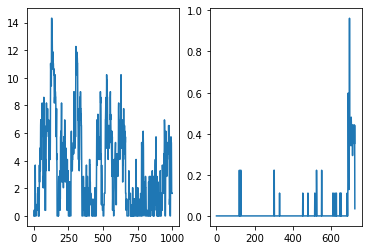

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 113.718
Episode: 21 Exploration P: 0.2781 Total reward: -3307.7639528011355 SOC: 0.1276 Cumulative_SOC_deviation: 554.8941 Fuel Consumption: 144.8678 Total Degradation: 481.1326

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 59.571
Episode: 22 Exploration P: 0.2707 Total reward: -1232.19724541921 SOC: 0.3526 Cumulative_SOC_deviation: 203.0129 Fuel Consumption: 75.0236 Total Degradation: 259.8967

../data/driving_cycles/city\01_FTP72_fuds.mat
battery power is 9344.08275176345(+) but condition is not avail
elapsed_time: 48.141
Episode: 23 Exploration P: 0.2648 Total reward: [-3281.83926082] SOC: -0.0008 Cumulative_SOC_deviation: 388.9850 Fuel Consumption: 68.0498 Total Degradation: 210.7856

../data/driving_cycles/city\06_udds_truck.mat


C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:270: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:271: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 45.138
Episode: 24 Exploration P: 0.2595 Total reward: -1607.9135357560488 SOC: 0.0977 Cumulative_SOC_deviation: 270.3143 Fuel Consumption: 67.1219 Total Degradation: 201.0121

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 46.351
Episode: 25 Exploration P: 0.2541 Total reward: -538.5286499261831 SOC: 0.6308 Cumulative_SOC_deviation: 81.5491 Fuel Consumption: 73.6989 Total Degradation: 206.0879

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 79.651
Episode: 26 Exploration P: 0.2451 Total reward: -1053.2936639527582 SOC: 0.3303 Cumulative_SOC_deviation: 155.7310 Fuel Consumption: 165.6272 Total Degradation: 490.3903

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 46.097
Episode: 27 Exploration P: 0.2401 Total reward: -722.5410779683017 SOC: 0.2694 Cumulative_SOC_deviation: 118.2716 F

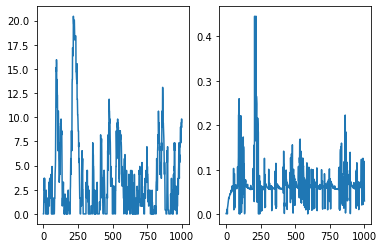

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 63.033
Episode: 41 Exploration P: 0.1542 Total reward: -224.8549057428937 SOC: 0.6765 Cumulative_SOC_deviation: 20.9924 Fuel Consumption: 105.1981 Total Degradation: 582.8431

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 112.495
Episode: 42 Exploration P: 0.1468 Total reward: -1193.5622034377227 SOC: 0.6000 Cumulative_SOC_deviation: 181.4500 Fuel Consumption: 159.2973 Total Degradation: 1097.0088

../data/driving_cycles/city\VITO_RW_Kangoo_DePost_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 115.061
Episode: 43 Exploration P: 0.1397 Total reward: -665.2715255831063 SOC: 0.5923 Cumulative_SOC_deviation: 87.9815 Fuel Consumption: 163.7770 Total Degradation: 1106.2856

../data/driving_cycles/city\wvucity.mat
maximum steps, simulation is done ... 
elapsed_time: 60.179
Episode: 44 Ex

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:270: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:271: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
******************* Test is start *****************
Total reward: -723.7435595122517 SOC: 0.4681 Cumulative_SOC_deviation: 117.7424 Fuel Consumption: 52.6117 Degradation total: 367.4071
******************* Test is done *****************



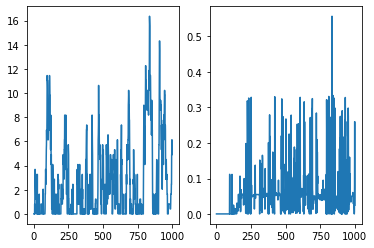

../data/driving_cycles/city\VITO_RW_Decade_Octavia_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 69.241
Episode: 61 Exploration P: 0.0877 Total reward: -384.3626719695122 SOC: 0.5789 Cumulative_SOC_deviation: 49.0465 Fuel Consumption: 104.7974 Total Degradation: 525.1290

../data/driving_cycles/city\VITO_RW_Decade_Octavia_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 64.034
Episode: 62 Exploration P: 0.0854 Total reward: -436.8603554915184 SOC: 0.5680 Cumulative_SOC_deviation: 54.9554 Fuel Consumption: 123.6146 Total Degradation: 482.5049

../data/driving_cycles/city\VITO_RW_Decade_Polo_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 63.080
Episode: 63 Exploration P: 0.0832 Total reward: -291.73137536960877 SOC: 0.5732 Cumulative_SOC_deviation: 32.6951 Fuel Consumption: 105.3693 Total Degradation: 432.0296

../data/driving_cycles/city\VITO_RW_Jumper_Brussels_101_1.mat
maximum steps, simulation is done ... 
elapsed_time: 112.5

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:270: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:271: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 58.975
Episode: 67 Exploration P: 0.0722 Total reward: -1226.4773307723428 SOC: 0.5480 Cumulative_SOC_deviation: 192.4911 Fuel Consumption: 129.2779 Total Degradation: 379.2866

../data/driving_cycles/city\06_udds_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 45.509
Episode: 68 Exploration P: 0.0709 Total reward: -959.511771687895 SOC: 0.5575 Cumulative_SOC_deviation: 150.3578 Fuel Consumption: 102.4725 Total Degradation: 313.4761

../data/driving_cycles/city\07_manhattan.mat
maximum steps, simulation is done ... 
elapsed_time: 46.691
Episode: 69 Exploration P: 0.0696 Total reward: -344.0262045072501 SOC: 0.5328 Cumulative_SOC_deviation: 49.2621 Fuel Consumption: 63.2320 Total Degradation: 271.2318

../data/driving_cycles/city\FTP_75_cycle.mat
maximum steps, simulation is done ... 
elapsed_time: 80.196
Episode: 70 Exploration P: 0.0674 Total reward: -1118.0915545362243 SOC: 0.5446 Cumulative_SOC_deviation: 163.7039 F

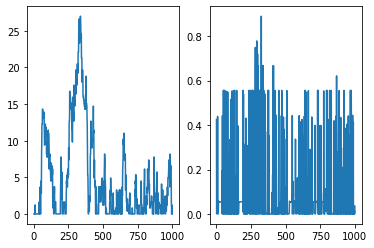

../data/driving_cycles/city\VITO_RW_Decade_Jumper_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 75.691
Episode: 81 Exploration P: 0.0502 Total reward: -332.67218856164453 SOC: 0.5605 Cumulative_SOC_deviation: 38.2485 Fuel Consumption: 114.6560 Total Degradation: 489.4052

../data/driving_cycles/city\VITO_RW_Decade_Jumper_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 85.826
Episode: 82 Exploration P: 0.0486 Total reward: -604.5059832882698 SOC: 0.5154 Cumulative_SOC_deviation: 81.8579 Fuel Consumption: 137.9161 Total Degradation: 542.6006

../data/driving_cycles/city\VITO_RW_Decade_Octavia_BCN_City1.mat
maximum steps, simulation is done ... 
elapsed_time: 69.293
Episode: 83 Exploration P: 0.0474 Total reward: -1402.4772975701653 SOC: 0.5074 Cumulative_SOC_deviation: 227.8285 Fuel Consumption: 103.8550 Total Degradation: 471.4817

../data/driving_cycles/city\VITO_RW_Decade_Octavia_MOL_City1.mat
maximum steps, simulation is done ... 
elapsed_time:

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:270: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment_essential_degradation\DDPG_adaptive_rewardfactor_final\vehicle_model_variant.py:271: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 80.321
Episode: 92 Exploration P: 0.0376 Total reward: -1864.8500747899839 SOC: 0.2529 Cumulative_SOC_deviation: 299.7234 Fuel Consumption: 156.4264 Total Degradation: 517.0758

../data/driving_cycles/city\nuremberg_r36.mat
maximum steps, simulation is done ... 
elapsed_time: 46.243
Episode: 93 Exploration P: 0.0371 Total reward: -984.6405236266983 SOC: 0.5165 Cumulative_SOC_deviation: 161.1144 Fuel Consumption: 66.2886 Total Degradation: 271.1596

../data/driving_cycles/city\ny_city_composite_truck.mat
maximum steps, simulation is done ... 
elapsed_time: 44.018
Episode: 94 Exploration P: 0.0365 Total reward: -336.49530564829416 SOC: 0.5787 Cumulative_SOC_deviation: 47.6365 Fuel Consumption: 64.9673 Total Degradation: 322.3704

../data/driving_cycles/city\ny_city_traffic.mat
maximum steps, simulation is done ... 
elapsed_time: 25.595
Episode: 95 Exploration P: 0.0362 Total reward: -166.25650525197085 SOC: 0.5639 Cumulative_SOC_deviat

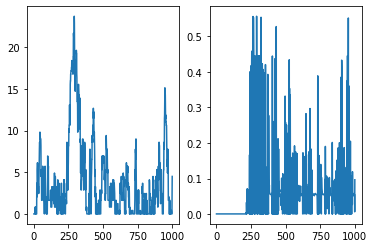

model is saved..


In [18]:
# print(env.version)

num_trials = 1
total_episodes = 100 
MAX_EPSILON = 0.5 

results_dict = {} 
driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")
reward_factor_opt = 5.7


for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    weights_root = "./noDegradation/reward_factor2"
    actor_model, critic_model, target_actor, target_critic, buffer = initialization(weights_root)
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = []
    episode_train_history = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes):
        i = ep % len(driving_cycle_paths)
        driving_cycle_path =driving_cycle_paths[i]
        print(driving_cycle_path)
        drv_cycle = sio.loadmat(driving_cycle_path)
        driving_cycle = drv_cycle["sch_cycle"][:, 1]

        env = initialization_env(driving_cycle, reward_factor_opt, consider_degradation)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_train_history.append(env.history)

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        degradation_total = np.sum(np.array(env.history["degradation"]))
        print(
            'Episode: {}'.format(ep + 1),
            "Exploration P: {:.4f}".format(eps),
            'Total reward: {}'.format(episodic_reward), 
            "SOC: {:.4f}".format(env.SOC), 
            "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
            "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
            "Total Degradation: {:.4f}".format(degradation_total)
        )
        print("")
        
        if (ep + 1) % 20 == 0: 
            history = test_agent(actor_model, reward_factor_opt, consider_degradation)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
          
    root = "./noDegradation/models_final"
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "train_history": episode_train_history, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [19]:
with open("noDegradation_adaptive_reward_factor_finalModel.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)